# TASK 4

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from utils.DataLoader import loadData

img_w, img_h = 128, 128
rel_path = 'Lab1/Skin/'
x_train, x_test, y_train, y_test = loadData(img_w, img_h, rel_path)

Reading: 0/1000 of train images
Reading: 100/1000 of train images
Reading: 200/1000 of train images
Reading: 300/1000 of train images
Reading: 400/1000 of train images
Reading: 500/1000 of train images
Reading: 600/1000 of train images
Reading: 700/1000 of train images
Reading: 800/1000 of train images
Reading: 900/1000 of train images
Reading: 0/200 of train images
Reading: 100/200 of train images


Matplotlib created a temporary config/cache directory at /tmp/matplotlib-pf95892n because the default path (/home/group_3/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


Learning rate: 0.0001, number of epochs: 50, neurons: 64
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 128, 128, 1)]     0         
                                                                 
 flatten (Flatten)           (None, 16384)             0         
                                                                 
 dense (Dense)               (None, 64)                1048640   
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Tota

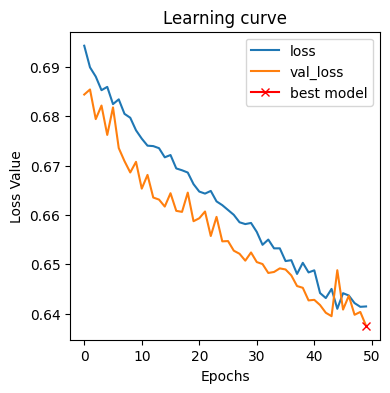

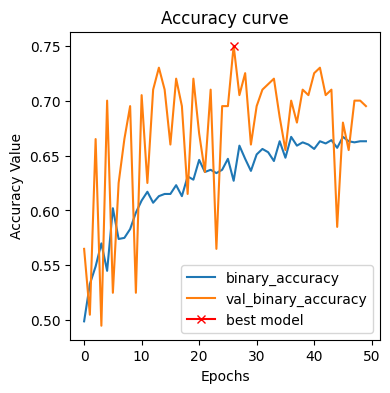

--- BEST MODEL ---
Validation loss: 0.6375312805175781
Validation accuracy: 0.6949999928474426
Learning rate: 0.1, number of epochs: 50, neurons: 64
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 128, 128, 1)]     0         
                                                                 
 flatten_1 (Flatten)         (None, 16384)             0         
                                                                 
 dense_4 (Dense)             (None, 64)                1048640   
                                                                 
 dense_5 (Dense)             (None, 32)                2080      
                                                                 
 dense_6 (Dense)             (None, 16)                528       
                                                                 
 dense_7 (Dense)             (None, 1)    

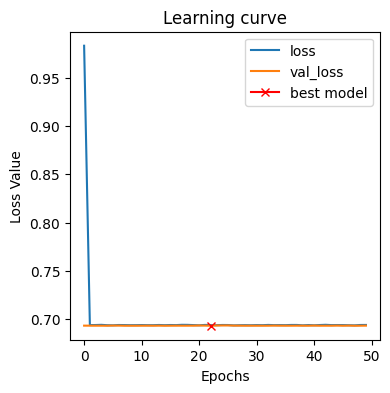

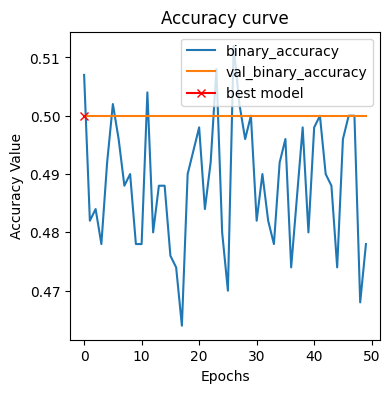

--- BEST MODEL ---
Validation loss: 0.6931471824645996
Validation accuracy: 0.5
Learning rate: 0.0001, number of epochs: 150, neurons: 256
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 128, 128, 1)]     0         
                                                                 
 flatten_2 (Flatten)         (None, 16384)             0         
                                                                 
 dense_8 (Dense)             (None, 256)               4194560   
                                                                 
 dense_9 (Dense)             (None, 128)               32896     
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dense_11 (Dense)            (None, 1)              

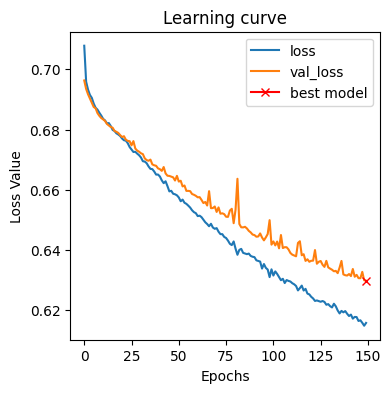

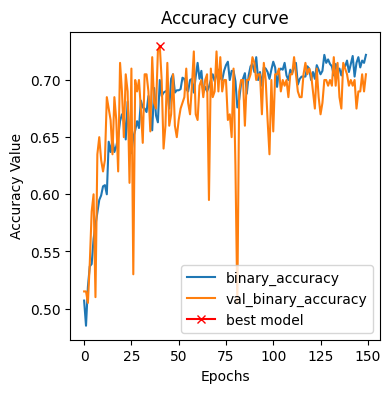

--- BEST MODEL ---
Validation loss: 0.6297673583030701
Validation accuracy: 0.7049999833106995


In [3]:
from tensorflow.keras.optimizers import SGD
from utils.Models import MyModel
import numpy as np
from utils.Plots import lossPlot, accuracyPlot

img_ch = 1
loss_function = 'BinaryCrossentropy'
parameters = [
    {
    "learning_rate": 0.0001, 
    "n_epochs": 50, 
    "base_dense": 64
    },
    {
    "learning_rate": 0.1, 
    "n_epochs": 50, 
    "base_dense": 64
    },
    {
    "learning_rate": 0.0001, 
    "n_epochs": 150, 
    "base_dense": 256
    }
]
n_batch = 16

for i in parameters:
    
    learning_rate, n_epochs, base_dense = i.values()

    print(f"Learning rate: {learning_rate}, number of epochs: {n_epochs}, neurons: {base_dense}")
    model = MyModel(img_w, img_h, img_ch, base_dense) 
    model.compile(loss=loss_function,
                    optimizer = SGD(learning_rate = learning_rate),
                    metrics=['binary_accuracy'])
    model_fit = model.fit(x_train, y_train, batch_size=n_batch, epochs=n_epochs, verbose=1, validation_data=[x_test,y_test])

    lossPlot(model_fit)
    accuracyPlot(model_fit)

    val_loss = model_fit.history["val_loss"]
    val_accuracy = model_fit.history["val_binary_accuracy"]
    min_loss = np.min(val_loss)
    print("--- BEST MODEL ---")
    print(f"Validation loss: {min_loss}")

    ind_min = val_loss.index(min_loss)
    val_acc = val_accuracy[ind_min]
    print(f"Validation accuracy: {val_acc}")
    print("------------------")